In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# import bisection
from joblib import Parallel, delayed
import scipy.spatial
import huffman
import GaussianSource as GS
import torch
# from rd_primal_minmax_gaussian_bisection import GenRD, GaussianDataset
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST,MNIST, CIFAR10
from torch.utils.data import DataLoader

device = 'cuda:3' if torch.cuda.is_available() else 'cpu'

In [3]:
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth':1.25})
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = None
plt.rcParams['legend.edgecolor'] = 'inherit'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams["font.family"] = "serif"

In [6]:
m = 20
r = 0.25
sigmas = 2*np.exp(-r*np.arange(m))
# sigmas = np.exp(-0.1*np.arange(m))

# m = 40
# r = 0.5
# sigmas = 2*np.exp(-r*np.arange(m))


In [7]:
GS.rd_gaussian(6, sigmas)*np.log(2)

1.0018930655219496

In [8]:
D_max =sum(sigmas**2)
DD = np.geomspace(0.01, 1.1*D_max, 100)
RR = []
for D in DD:
    RR.append(GS.rd_gaussian(D, sigmas))
DD = np.array(DD)
RR = np.array(RR)

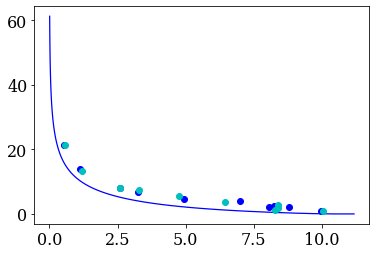

In [17]:
plt.plot(DD, RR)
plt.plot(rd_PFR[:,1], rd_PFR[:,0], 'o', color='b')
plt.plot(rd_ORC[:,1], rd_ORC[:,0], 'o', color='c')

In [11]:
# sigmas = np.exp(-0.25*np.arange(m))
# sigmas = np.ones(m)
RR_PFR = []
DD_PFR = []
sweep = np.linspace(0.001, 1.1*D_max, 10)
N = 500000
rd_PFR = np.array(Parallel(n_jobs=-1)(delayed(GS.RD_PFR_block)(D, sigmas, N, method='PFR') for D in sweep))

RR_ORC = []
DD_ORC = []
sweep = np.linspace(0.001, 1.1*D_max, 10)
N = 500000
rd_ORC = np.array(Parallel(n_jobs=-1)(delayed(GS.RD_PFR_block)(D, sigmas, N, method='ORC') for D in sweep))

11.1821 finished
8.6974 finished
9.9397 finished
7.4550 finished
6.2127 finished
4.9704 finished
3.7280 finished
2.4857 finished
1.2433 finished
0.0010 finished
11.1821 finished
8.6974 finished
9.9397 finished
7.4550 finished
4.9704 finished
6.2127 finished
3.7280 finished
2.4857 finished
1.2433 finished
0.0010 finished


In [35]:
# r = 0.25
RR_DNN = np.array([ 2, 4.     ,  6.     ,  8.     , 12.     , 14.33985, 18.     ])
dists_DNN = np.array([6.80288408, 4.62322701, 4.03686346, 2.43354822, 1.75967654,
       1.58059808, 0.93856596])

rates=[12.31384377670288, 11.704520959854126, 10.74131981086731, 9.191900667190552, 8.085918065071105, 6.424460682868958, 3.8615370178222657, 1.9160651941299438, 0.6371926188468933]
rates_ORD_zipf=[15.886339999999999, 15.177240000000017, 14.033780000000005, 12.27118, 11.05542, 9.218759999999996, 6.5226799999999985, 4.236160000000002, 2.8420399999999986]
rates_PFR_zipf=[16.10083999999999, 15.330780000000008, 14.161640000000004, 12.328639999999998, 11.068260000000002, 9.236500000000005, 6.506060000000007, 4.22678, 2.7929999999999984]
rates_PFR_UB=[21.048699016620496, 20.371791032504085, 19.294842492871513, 17.541251883987087, 16.26955036059909, 14.31674691438378, 11.142949524538121, 8.460088168320365, 6.348416686478992]
dists_alt=[0.9834443533420563, 1.0382319754362106, 1.1565690186023712, 1.405188731431961, 1.5964484493732451, 2.0744748046398165, 3.3516697196960448, 5.262713115692138, 7.732288404464722]
dists_PFR=[0.8851438326835632, 0.9492624145746231, 1.0806331841945649, 1.3571702213287353, 1.5633492295742035, 2.0551645567417145, 3.3625454964637758, 5.302312511920929, 7.790994309425354]
dists_ORD=[0.9009656332731247, 0.9646668192148209, 1.0951631202697754, 1.3678174753189087, 1.5678244707584381, 2.0623714306354524, 3.3410087780952455, 5.282084590435028, 7.677666803359985]


In [10]:
#NERD
trainset = GaussianDataset(n_samples=30000, m=m, r=r)
loader = torch.utils.data.DataLoader(trainset, batch_size=30000,
                                              shuffle=True, num_workers=2, pin_memory=True)

DD_ = [9,8,7,6,5,4,3,2,1.5,1]
# DD_ = [70, 60, 50, 40, 30, 20, 15, 10]
# DD_.reverse()
# DD_ = np.array(DD_)*10
rates_true_rd = []
dists_true_rd = []
for D in DD_:
    # eps = 1e-10 if D in [1, 1.5] else 1e-20
    eps = 1e-14
    model = GenRD(latent_dim=m, D=D, eps=eps)
    checkpoint = torch.load(f'trained_gaussian/trained_genRD_minmax_gaussian/GenRD_trained_genRD_minmax_gaussian_D{D:.3f}.pt')
    model.load_state_dict(checkpoint)
    model.to(device)
    # eps = 1e-20 if D == 1 else 1e-20
    r, d, beta = calc_RD(loader, model, D, eps=1e-30) 
    print(f'r={r:.4f}, d_alt={d:.4f}, d={D:.4f}, beta={beta:.4f}')
    rates_true_rd.append(r)
    dists_true_rd.append(d)

r=0.2422, d_alt=9.0000, d=9.0000, beta=-0.1691
r=0.5390, d_alt=8.0000, d=8.0000, beta=-0.2296
r=0.9230, d_alt=7.0000, d=7.0000, beta=-0.3018
r=1.4345, d_alt=6.0000, d=6.0000, beta=-0.4009
r=2.1092, d_alt=5.0000, d=5.0000, beta=-0.5448
r=3.0432, d_alt=4.0000, d=4.0000, beta=-0.7595
r=4.4105, d_alt=3.0000, d=3.0000, beta=-1.1550
r=6.6652, d_alt=2.0000, d=2.0000, beta=-2.0425
r=8.5403, d_alt=1.5031, d=1.5000, beta=-3.4203
r=13.1134, d_alt=1.1028, d=1.0000, beta=-8.9471


In [81]:
dists_PFR_1000 = 
rates_PFR_zipf_1000 = 
dists_PFR_10000 = [1.0932029715776443, 1.132364910364151, 1.2230347933769226, 1.4388755421638488, 1.6159701998233795, 2.075870683431625, 3.3325889010429384, 5.244371365070343, 7.776245896339416] 
rates_PFR_zipf_10000 = [14.26554000000001, 13.834719999999994, 13.090980000000007, 11.810519999999993, 10.71442, 9.038459999999993, 6.431439999999997, 4.237839999999998, 2.721319999999999]  
dists_PFR_100000=[0.8851438326835632, 0.9492624145746231, 1.0806331841945649, 1.3571702213287353, 1.5633492295742035, 2.0551645567417145, 3.3625454964637758, 5.302312511920929, 7.790994309425354]
rates_PFR_zipf_100000=[16.10083999999999, 15.330780000000008, 14.161640000000004, 12.328639999999998, 11.068260000000002, 9.236500000000005, 6.506060000000007, 4.22678, 2.7929999999999984]

7.357744708533713

In [11]:
from scipy.stats import ortho_group
np.random.seed(seed=233423)
U = ortho_group.rvs(m)

In [95]:
GS.rd_gaussian(70, sigmas)

3.269301444873266

(0.0, 20.0)

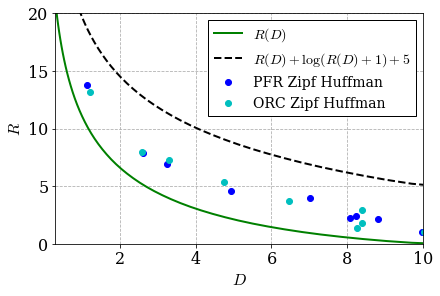

In [19]:
plt.figure(1, constrained_layout=True)
plt.plot(DD, RR, '-', color='g', linewidth=2, label=r'$R(D)$')
# plt.plot(DD_, rates_true_rd, 'o', color='k', label=r'$\widehat{R_\Theta(D)}_n$', fillstyle='none')
plt.plot(DD, RR+np.log2(RR+1)+5, '--', color='k', linewidth=2, label=r'$R(D)+\log(R(D)+1)+5$')
# plt.plot(dists_DNN, RR_DNN, '-o', color='r', label='DNN Compressor')
plt.plot(rd_PFR[:,1], rd_PFR[:,0], 'o', color='b', label='PFR Zipf Huffman')
plt.plot(rd_ORC[:,1], rd_ORC[:,0], 'o', color='c', label='ORC Zipf Huffman')
# plt.axvline(sum(sigmas**2),  **{'linestyle':'--', 'color': 'm'}, linewidth=2)
plt.xlabel('$D$')
plt.ylabel('$R$')
plt.grid(linestyle='dashed')
plt.legend(fontsize=14)
plt.xlim([0.3, 10])
plt.ylim([0, 20])
# plt.plot(DD, R)
# plt.savefig('plots/gaussian_NERD2.pdf')
# plt.savefig('plots/gaussian_m20_r.25.pdf')

In [42]:
dists_PFR, rates_PFR_zipf

([0.8851438326835632,
  0.9492624145746231,
  1.0806331841945649,
  1.3571702213287353,
  1.5633492295742035,
  2.0551645567417145,
  3.3625454964637758,
  5.302312511920929,
  7.790994309425354],
 [16.10083999999999,
  15.330780000000008,
  14.161640000000004,
  12.328639999999998,
  11.068260000000002,
  9.236500000000005,
  6.506060000000007,
  4.22678,
  2.7929999999999984])

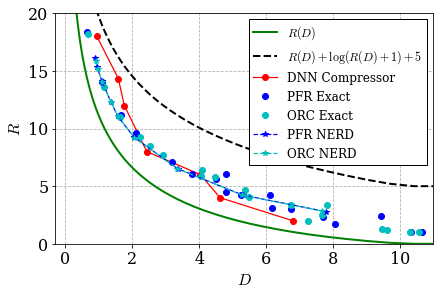

In [56]:
plt.figure(1, constrained_layout=True)
plt.plot(DD, RR, '-', color='g', linewidth=2, label=r'$R(D)$')
# plt.plot(DD_, rates_true_rd, 'o', color='k', label=r'$\widehat{R_\Theta(D)}_n$', fillstyle='none')
plt.plot(DD, RR+np.log2(RR+1)+5, '--', color='k', linewidth=2, label=r'$R(D)+\log(R(D)+1)+5$')
plt.plot(dists_DNN, RR_DNN, '-o', color='r', label='DNN Compressor')
plt.plot(rd_PFR[:,1], rd_PFR[:,0], 'o', color='b', label='PFR Exact')
plt.plot(rd_ORC[:,1], rd_ORC[:,0], 'o', color='c', label='ORC Exact')
plt.plot(dists_PFR, rates_PFR_zipf, '--*', color='b', label='PFR NERD')
plt.plot(dists_ORD, rates_ORD_zipf, '--*', color='c', label='ORC NERD')
# plt.axvline(sum(sigmas**2),  **{'linestyle':'--', 'color': 'm'}, linewidth=2)
plt.xlabel('$D$')
plt.ylabel('$R$')
plt.grid(linestyle='dashed')
plt.legend(fontsize=12)
plt.xlim([-0.3, 11])
plt.ylim([0, 20])
# plt.plot(DD, R)
# plt.savefig('plots/RCC_Gaussian_both.pdf')
# plt.savefig('plots/gaussian_m20_r.25.pdf')

In [7]:
def calc_RD(loader, model, D, eps=1e-14):
    Rate = 0
    Dist = 0
    model.to(device)
    with torch.no_grad():
        for x in loader:
            x = x.to(device)
            z = torch.randn(x.shape[0], model.latent_dim).to(device)
            y = model.generator(z).to(device)
#             print(x.device, y.device)
            dist_mat = model._squared_distances(x,y)
            # print('hello')
            beta = model.inner_max(dist_mat)
            # print('hello2')
            # print(beta)
            # eps = 1e-20#1e-14 # 1e-10 for FMNIST, 1e-14 for MNIST
            C = torch.exp(beta*dist_mat)
            mean_z = torch.mean(C, dim=1)
            # I = (mean_z > eps)
            R = beta*D - torch.mean(torch.log(mean_z+eps))
            # D = torch.mean(C*torch.exp(beta*C) / (torch.mean(torch.exp(beta*C), dim=1)[:,None])+1e-14)
            # D = torch.mean(C*torch.exp(beta*C) / ((mean_z+eps)[:,None]))
            
            # denom_x = torch.mean(torch.exp(beta*dist_mat), dim=1) + eps
            # f_xy = dist_mat*torch.exp(beta*dist_mat) / denom_x[:,None]
            # D = torch.mean(f_xy)
            
            denom_x = torch.mean(torch.exp(beta*dist_mat), dim=1) 
            log_f_xy = torch.log(dist_mat)+beta*dist_mat-torch.log(denom_x[:,None] + eps)
            D = torch.mean(torch.exp(log_f_xy))
        
            Rate += R.item()
            Dist += D.item()
    return (Rate/np.log(2))/len(loader), Dist/len(loader), beta

def calc_RD2(loader, model, D, eps=1e-14):
    Rate = 0
    Dist = 0
    model.to(device)
    with torch.no_grad():
        for x in loader:
            x = x.to(device)
            z = torch.randn(x.shape[0], model.latent_dim).to(device)
            y = model.generator(z).to(device)
#             print(x.device, y.device)
            dist_mat = model._squared_distances(x,y)
            beta = model.inner_max(dist_mat)
            # print(beta)
            # eps = 1e-20#1e-14 # 1e-10 for FMNIST, 1e-14 for MNIST
            C = torch.exp(beta*dist_mat)
            mean_z = torch.mean(C, dim=1)
            # I = (mean_z > eps)
            mean_z[mean_z < eps] = eps
            R = beta*D - torch.mean(torch.log(mean_z))
            # D = torch.mean(C*torch.exp(beta*C) / (torch.mean(torch.exp(beta*C), dim=1)[:,None])+1e-14)
            # D = torch.mean(C*torch.exp(beta*C) / ((mean_z+eps)[:,None]))
            
            denom_x = torch.mean(torch.exp(beta*dist_mat), dim=1) 
            denom_x[denom_x < eps] = eps
            f_xy = dist_mat*torch.exp(beta*dist_mat) / denom_x[:,None]
            D = torch.mean(f_xy)
            
            Rate += R.item()
            Dist += D.item()
    return (Rate/np.log(2))/len(loader), Dist/len(loader), beta

In [98]:
sweep = np.linspace(0.7, 1.3, 50)
RR = []
DD = []
for lam in sweep:
    ent, dist, _, _ = GS.lloyd_max_ent(5, 0.5, lam)
    RR.append(ent)
    DD.append(dist)

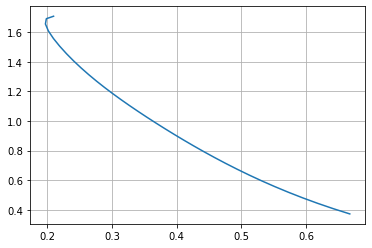

In [104]:
plt.plot(DD, RR)
plt.grid()